# packages

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker
import seaborn as sns
import pandas as pd
import numpy as np
import xarray as xr
import scipy
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Helvetica'
plt.rcParams['font.size'] = 12
%config InlineBackend.figure_format='retina'
plt.style.use('ggplot')
plt.rcParams['axes.labelsize']='7'
plt.rcParams['axes.titlesize']='7'
plt.rcParams['axes.labelsize']='7'
plt.rcParams['xtick.labelsize']='7'
plt.rcParams['ytick.labelsize']='7'
plt.rcParams['axes.linewidth']='0.5'
plt.rcParams['xtick.major.width']='0.5'
plt.rcParams['ytick.major.width']='0.5'
plt.rcParams['xtick.major.size']='3'
plt.rcParams['ytick.major.size']='3'
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'

# read

In [2]:
ds=xr.open_dataset("h.pres.01011980-15072025.nc")

In [25]:
ds

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 16628, lon: 201, lat: 141, plev: 1)
Coordinates:
  * time     (time) datetime64[ns] 133kB 1980-01-01T12:00:00 ... 2025-07-10T1...
  * lon      (lon) float64 2kB -20.0 -19.75 -19.5 -19.25 ... 29.5 29.75 30.0
  * lat      (lat) float64 1kB 70.0 69.75 69.5 69.25 ... 35.75 35.5 35.25 35.0
  * plev     (plev) float64 8B 5e+04
Data variables:
    z        (time, plev, lat, lon) float32 2GB ...
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Jul 15 20:01:00 2025: cdo -f nc4 copy data.grib data.nc
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

In [36]:
time = pd.date_range(start='1980-01-01', periods=16628, freq='D')
years = [1980, 1989, 1998, 2007, 2016, 2025]
# Extract and print indices
for year in years:
    target_date = pd.Timestamp(year=year, month=1, day=1) + pd.Timedelta(days=182)
    index = np.where(time == target_date)[0][0]
    print(f"Index of day 183 in {year} ({target_date.date()}): {index}")

Index of day 183 in 1980 (1980-07-01): 182
Index of day 183 in 1989 (1989-07-02): 3470
Index of day 183 in 1998 (1998-07-02): 6757
Index of day 183 in 2007 (2007-07-02): 10044
Index of day 183 in 2016 (2016-07-01): 13331
Index of day 183 in 2025 (2025-07-02): 16619


# check

In [ ]:
z_1980 = ds['z'].sel(time='1980-01-01T12:00:00')

# figure varie intro

In [ ]:
path = "fgs/geo/"
for i in range(30):
    z_slice = ds['z'].isel(time=i, plev=0)
    time_str = z_slice['time'].dt.strftime('%Y-%m-%d').item()
    plt.figure(figsize=(8,6))
    z_slice.plot()
    plt.title(f"500 hPa Geopotential on {time_str}")
    plt.savefig(path+f'geopot_{i}.png',dpi=100)

## annual trend

In [6]:
path='fgs/atrend/'
plt.figure(figsize=(24,6))
z_height = ds['z'].isel(plev=0) / 9.81  #to meters
z_point = z_height.isel(lat=10, lon=10)  # dims: time
z_by_year = z_point.groupby('time.year')
for year, z_year in z_by_year:
    plt.figure(figsize=(24, 6))
    z_year.plot.line(color='purple', marker='o')
    plt.title(
        f'500 hPa geopotential height at gridpoint (index 10,10) - year {year}',
        fontsize=25, weight='bold')
    plt.ylabel('Height [m]', fontsize=19, weight='bold')
    plt.xlabel('Date', fontsize=19, weight='bold')
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)
    plt.tight_layout()
    plt.savefig(f'{path}atrend_{year}.png', dpi=100)
    plt.close()

<Figure size 2400x600 with 0 Axes>

## latvarie

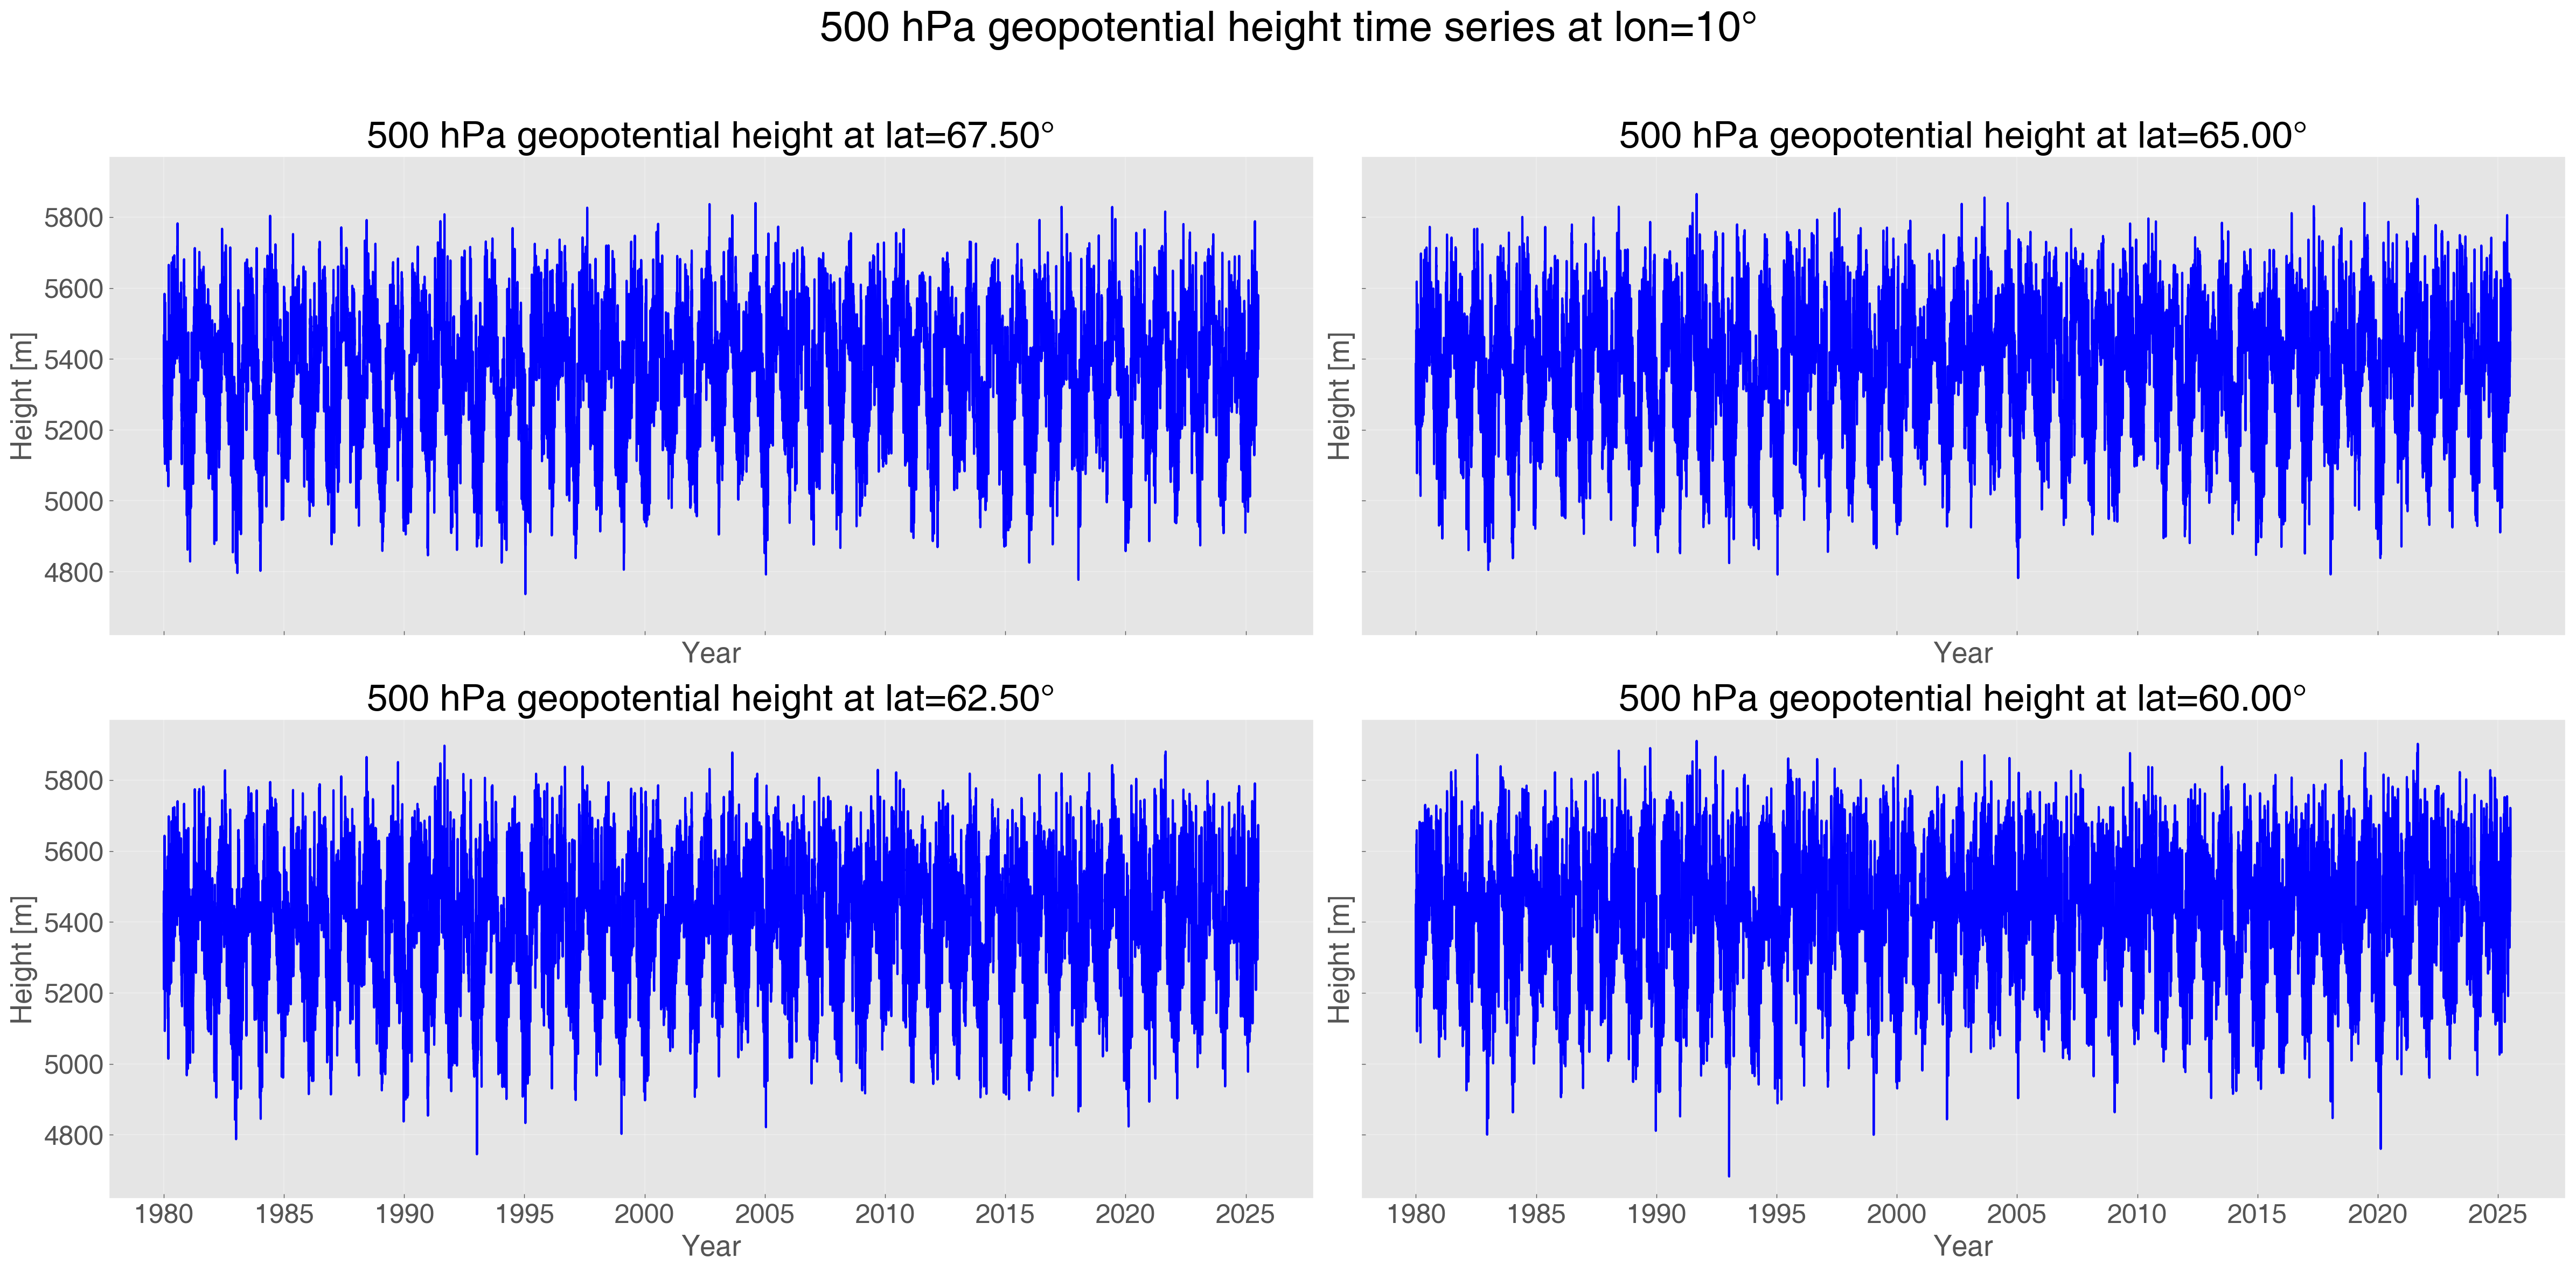

In [16]:
path='fgs/latvarie/'
z_height = ds['z'].isel(plev=0) / 9.81  #to meters
lon_index = 10# 1 long for slicing over time array
lat_indices = [10, 20, 30, 40]#4 lats for 2by2 grid
lat_values = z_height['lat'].isel(lat=lat_indices).values
n_rows = 2#4by4 subplot
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 12), sharex=True, sharey=True)
axes_flat = axes.flatten()#indexing
for i, ax in enumerate(axes_flat):
    lat_idx = lat_indices[i]
    lat_val = lat_values[i]
    z_series = z_height.isel(lat=lat_idx, lon=lon_index)#get data at lat/lon
    z_series.plot.line(ax=ax, color='blue',add_legend=True)
    ax.set_title(f'500 hPa geopotential height at lat={lat_val:.2f}°',fontsize=20, weight='bold')
    ax.set_xlabel('Year', fontsize=19, weight='bold')
    ax.set_ylabel('Height [m]', fontsize=19, weight='bold')
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=18)
fig.suptitle('500 hPa geopotential height time series at lon=10°', fontsize=28, weight='bold')
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(path+f'geoseries_{lat_idx}_{lat_val}.png',dpi=100)
plt.close()
#different latitudes? lat_indices = [5, 15, 25, 35]
#another longitude? lon_index = 12

## annual mean

In [ ]:
z_height = (ds['z'].isel(plev=0) / 9.81).load()#500 hPa level geopotential height
path='fgs/amean/' 
times_jan1 = z_height['time'].dt.month == 1 #dates at January 1st
times_jan1 = times_jan1 & (z_height['time'].dt.day == 1)
z_jan1_maps = z_height.where(times_jan1, drop=True)
for i in range(len(z_jan1_maps['time'])):
    z_map = z_jan1_maps.isel(time=i)
    date_str = pd.to_datetime(z_map['time'].values).strftime('%Y-%m-%d')
    plt.figure(figsize=(14,7))
    z_map.plot(cmap='bwr', cbar_kwargs={'label': 'Geopotential height [m]'})
    plt.title(f'500 hPa Geopotential height on {date_str}', fontsize=25, weight='bold')
    plt.xlabel('Longitude', fontsize=19, weight='bold')
    plt.ylabel('Latitude', fontsize=19, weight='bold')
    plt.savefig(path+'annmean.png', dpi=120)
    plt.close()

## plot

In [36]:
path='fgs/maps/'
for i in range(30): # loop over multiple days
    z_slice = ds['z'].isel(time=i, plev=0)
    time_str = pd.to_datetime(z_slice['time'].values).strftime('%Y-%m-%d %H:%M')
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-20, 30, 35, 70], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabel_style = {'size': 15, 'color': 'gray'}
    gl.xlabel_style = {'color': 'red', 'weight': 'bold'}
    gl.xlabels_top=False
    gl.ylabels_right=False
    # plt.xticks(ticks=z_slice['lon'].values[::5],  # every 5th tick
    #            labels=[f"{v:.1f}°E" for v in z_slice['lon'].values[::5]], fontsize=10, rotation=45)
    # plt.yticks(ticks=z_slice['lat'].values[::5], labels=[f"{v:.1f}°N" for v in z_slice['lat'].values[::5]], fontsize=10)
    plot = z_slice.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu', add_colorbar=False)
    cb = plt.colorbar(plot, ax=ax, orientation="vertical", pad=0.05)
    mean = z_slice.mean().item()  # scalar value
    std = z_slice.std().item()
    rms = np.sqrt((z_slice**2).mean()).item()
    cb.set_label(label=f'Geopotential ($m^2/s^2$)\n Mean: {mean_val:.2f}\n $\sigma$: {std_val:.2f}, rms: {rms:.2f}',size='large', weight='bold')
    cb.ax.tick_params(labelsize=20) 
    cb.ax.plot(0.8, mean, 'w.')
    cb.ax.axhline(rms, c='w')
    plt.xlabel("Longitude (degrees)", fontsize=19, weight='bold')
    plt.ylabel("Latitude (degrees)", fontsize=19, weight='bold')
    ax.set_title(f"ERA5 500 hPa geopotential height on {time_str}", fontsize=22, weight='bold')
    plt.savefig(path + f'map_{i}.png', dpi=100)
    plt.close()
print(f"Generated 30 maps with mean and std in colorbar label, saved to {path}")

Generated 30 maps with mean and std in colorbar label, saved to fgs/maps/


# contour plot

In [ ]:
path='fgs/ccont/'
time = ds['time'].values
plev = ds['plev'].values
lat = ds['lat'].values
lon = ds['lon'].values
print('Time range:', time[0], 'to', time[-1])
print('Pressure levels (hPa):', plev/100.)
target_time = np.datetime64('2025-02-07T12:00:00')#183th day middle day of year, too images
time_ind = np.where(time == target_time)[0][0]
lvl_ind = np.where(plev == 50000.)[0][0]  # 50000 Pa
print('Selected time index:', time_ind, 'Selected level index:', lvl_ind)
geopot = ds['z'].values
geopot_height = geopot / 9.81
geopot_hght_trimmed = geopot_height[time_ind, lvl_ind, :, :]
X, Y = np.meshgrid(lon, lat)
print('Grid shape:', X.shape, Y.shape, geopot_hght_trimmed.shape)
proj = ccrs.LambertConformal(central_longitude=10.0, central_latitude=50.0)
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection=proj)
ax.set_extent([-25, 35, 35, 75], crs=ccrs.PlateCarree())
levels = np.arange(480, 600 + 2, 4)  # 4800–6000 meters as 480–600 dm
cfill = ax.contourf(X, Y, geopot_hght_trimmed / 10.,  #to decameters
levels=levels,cmap='nipy_spectral',transform=ccrs.PlateCarree(),extend='both')
cline = ax.contour(X, Y, geopot_hght_trimmed / 10.,levels=levels[::2],
    colors='black',linewidths=1,transform=ccrs.PlateCarree())
ax.clabel(cline, fmt='%d', fontsize=12)
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')
ax.add_feature(cfeature.LAKES, facecolor='none', edgecolor='black')
ax.add_feature(cfeature.RIVERS, linewidth=0.5, edgecolor='blue')
gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),
linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 19, 'weight': 'bold'}
gl.ylabel_style = {'size': 19, 'weight': 'bold'}
gl.xlocator = mticker.FixedLocator(z_slice['lon'].values[::5])
gl.ylocator = mticker.FixedLocator(z_slice['lat'].values[::5])
cbar = plt.colorbar(cfill, orientation='vertical', pad=0.02, aspect=30, shrink=1)
cbar.set_label('500 hPa geopotential height [dm]', fontsize=19)
cbar.ax.tick_params(labelsize=17)
ax.text(0.5, -0.05, 'Longitude (degrees)', va='center', ha='center',
fontsize=19, weight='bold', transform=ax.transAxes)
ax.text(-0.12, 0.5, 'Latitude (degrees)', va='center', ha='center',
rotation='vertical', fontsize=19, weight='bold', transform=ax.transAxes)
time_label = pd.to_datetime(time[time_ind]).strftime('%Y-%m-%d %H:%M UTC')
ax.set_title(f'ERA5 500 hPa geopotential height\n Date and time: {time_label}', fontsize=20, weight='bold')
plt.tight_layout()
plt.savefig(path+f'cplot_{time_label}.png',dpi=100)
plt.close()

## amean

In [ ]:
years_to_plot = [1980, 1989, 1998, 2007, 2016, 2025]
path='fgs/amean/'
fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # 1 row, 2 columns for side-by-side plots
colors = plt.cm.berlin(np.linspace(0, 1, len(years_to_plot))) 
for i, year in enumerate(years_to_plot):
    date_to_select = f"{year}-07-02T12:00:00"
    try:
        ds_date_time = ds['z'].sel(time=date_to_select, method='nearest').isel(plev=0)
        print(f"Successfully selected data for {year}-07-02 12:00:00")
    except KeyError:
        print(f"Warning: Data for {year}-07-02 12:00:00 not found or exact match not possible. Using nearest available time.")
        ds_date_time = ds['z'].sel(time=date_to_select, method='nearest').isel(plev=0)
    except Exception as e:
        print(f"An error occurred while selecting data for {year}: {e}")
        continue 
    zonal_mean_z = ds_date_time.mean(dim='lon')
    meridional_mean_z = ds_date_time.mean(dim='lat')
    zonal_mean_z.plot(ax=axes[0], color=colors[i], label=f'{year}-07-02 12:00:00 UTC', add_legend=False)
    meridional_mean_z.plot(ax=axes[1], color=colors[i], label=f'{year}-02-07 12:00:00 UTC', add_legend=False)
axes[0].set_title('Zonal mean geopotential height ', fontsize=18,weight='bold')
axes[0].set_xlabel('Latitude (°)', fontsize=12,weight='bold')
axes[0].set_ylabel('Geopotential height (m$^2$/s$^2$)', fontsize=12,weight='bold')
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].tick_params(labelsize=15)
axes[0].legend(title='Date', loc='best', fontsize=12) 
axes[1].set_title('Meridional mean geopotential height ', fontsize=18, weight='bold')
axes[1].set_xlabel('Longitude (°)', fontsize=12)
axes[1].set_ylabel('Geopotential height (m$^2$/s$^2$)', fontsize=12, weight='bold')
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].tick_params(labelsize=15)
axes[1].legend(title='Date', loc='best', fontsize=12) 
plt.tight_layout()
plt.savefig(path+'ameanl.png',dpi=150)
plt.close()

# data analysis

In [3]:
from scipy.spatial.distance import cdist
from scipy.stats import linregress, norm

In [ ]:
z_daily = ds['z'].sel(plev=50000, drop=True).resample(time='1D').mean()

In [ ]:
path='daily/'#dimensions: (time: Ndaily, lat: M, lon: K)
for i in range(13331, min(13333, z_daily.time.size), 1):
    #z_daily.isel(time=i).plot()
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-20, 30, 35, 70], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.xlabel_style = {'size': 15, 'color': 'gray'}
    gl.xlabel_style = {'color': 'red', 'weight': 'bold'}
    gl.xlabels_top=False
    gl.ylabels_right=False
    plot = z_daily.isel(time=i).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu', add_colorbar=False);
    cb = plt.colorbar(plot, ax=ax, orientation="vertical", pad=0.05)
    cb.set_label(label=f'Geopotential ($m^2/s^2$)',size='large', weight='bold')
    cb.ax.tick_params(labelsize=20) 
    plt.xlabel("Longitude (degrees)", fontsize=19, weight='bold')
    plt.ylabel("Latitude (degrees)", fontsize=19, weight='bold')
    ax.set_title(f"Daily 500 hPa Geopotential - {str(z_daily.time.values[i])[:10]}", fontsize=22, weight='bold')
    plt.savefig(path+f'daily_{str(z_daily.time.values[i])[:10]}.png',dpi=110);

In [26]:
#Flatten lat-lon to vector:

In [5]:
maps = z_daily.values.reshape(z_daily.time.size, -1)
print("Maps matrix shape:", maps.shape)
#regularization: 
maps -= maps.mean(axis=1, keepdims=True)
print("Maps matrix shape after regularz:", maps.shape)
##Z-score per grid point/ mean std per grid point over time
mean = maps.mean(axis=0)
std = maps.std(axis=0)
maps = (maps - mean) / std #normalize
print("Maps matrix shape after regularz:", maps.shape)

Maps matrix shape: (16628, 28341)
Maps matrix shape after regularz: (16628, 28341)
Maps matrix shape after regularz: (16628, 28341)


In [ ]:
path='danl/'#mean and std-dev done over time
mean_field = z_daily.mean(dim='time')
std_field = z_daily.std(dim='time')
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-20, 30, 35, 70], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'red', 'weight': 'bold'}
gl.xlabels_top=False
gl.ylabels_right=False
plot = mean_field.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu', add_colorbar=False)
cb = plt.colorbar(plot, ax=ax, orientation="vertical", pad=0.05)
cb.set_label(label=f'Geopotential ($m^2/s^2$)',size='large', weight='bold')
cb.ax.tick_params(labelsize=16) 
plt.xlabel("Longitude (degrees)", fontsize=19, weight='bold')
plt.ylabel("Latitude (degrees)", fontsize=19, weight='bold')
ax.set_title(f"ERA5 Mean 500 hPa geopotential field 19800101-11072025", fontsize=18, weight='bold')
plt.savefig(path+f'mean_wholeZ.png',dpi=110)
plt.close()
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-20, 30, 35, 70], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'red', 'weight': 'bold'}
gl.xlabels_top=False
gl.ylabels_right=False
plot = std_field.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu', add_colorbar=False)
cb = plt.colorbar(plot, ax=ax, orientation="vertical", pad=0.05)
cb.set_label(label=f'Geopotential ($m^2/s^2$)',size='large', weight='bold')
cb.ax.tick_params(labelsize=16) 
plt.xlabel("Longitude (degrees)", fontsize=19, weight='bold')
plt.ylabel("Latitude (degrees)", fontsize=19, weight='bold')
ax.set_title(f"ERA5 $\sigma$ of 500 hPa geopotential field 19800101-11072025", fontsize=18, weight='bold')
plt.savefig(path+f'stddev_wholeZ.png',dpi=110);

In [6]:
# Distance matrix: each row i is distances from map i to all others
dist_matrix = cdist(maps, maps, metric='euclidean')
print("Distance matrix shape:", dist_matrix.shape)

Distance matrix shape: (16628, 16628)


In [ ]:
fig = plt.figure(figsize=(12, 8))
path='anys/'
sns.histplot(dist_matrix.flatten(), bins=100, kde=True)
plt.title("Distribution of pairwise Euclidean distances", fontsize=18, weight='bold')
plt.xlabel("Distance", fontsize=19, weight='bold')
plt.ylabel("Bin count", fontsize=19, weight='bold')
plt.legend()
plt.savefig(path+f'euclid1.png',dpi=110);

In [ ]:
ref_day = 16619  # 183 3471 6757 10044 13332 16619
ref_distances = dist_matrix[ref_day]
ref_distances[ref_day] = np.inf
plt.figure(figsize=(8,5))
sns.histplot(ref_distances, bins=100, kde=True)
plt.title(f"Distance distribution from reference day {z_daily.time.values[ref_day]}", fontsize=12, weight='bold')
plt.xlabel("Distance", fontsize=19, weight='bold')
plt.ylabel("Bin count", fontsize=19, weight='bold')
plt.legend()
plt.savefig(path+f'dist_distr_{ref_day}1.png',dpi=110);

In [10]:
quantiles = [0.98, 0.99, 0.995]
Ndaily = z_daily.time.size
analog_counts_per_quantile = {}#analog counts per period for each quantile

analog counts per quantile: {}


In [11]:
time_index = pd.to_datetime(z_daily.time.values)
period_edges = pd.qcut(np.arange(Ndaily), q=5, labels=False) + 1

In [ ]:
q = 0.98
Ndaily = z_daily.time.size
k = int(np.floor((1 - q) * Ndaily))
analog_indices = np.argpartition(ref_distances, k)[:k]
print(f"{k} closest analog indices:", analog_indices)#reference map vs. mean of analogs
ref_map = z_daily.isel(time=ref_day)
analog_maps = z_daily.isel(time=analog_indices).mean(dim='time')
fig = plt.figure(figsize=(7, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title(f"ERA5 reference day map - {z_daily.time.values[ref_day]}", fontsize=12, weight='bold')
ax.set_extent([-20, 30, 35, 70], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plot = ref_map.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu', add_colorbar=False)
cb = plt.colorbar(plot, ax=ax, orientation="vertical", pad=0.05)
cb.set_label(label='Geopotential ($m^2/s^2$)', size='large', weight='bold')
cb.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig(path + f"reference_map_{ref_day}1.png", dpi=110)
plt.close()
fig = plt.figure(figsize=(7, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title(f"Mean of {k} closest analogs (q={q})", fontsize=12, weight='bold')
ax.set_extent([-20, 30, 35, 70], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plot = analog_maps.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='RdBu', add_colorbar=False)
cb = plt.colorbar(plot, ax=ax, orientation="vertical", pad=0.05)
cb.set_label(label='Geopotential ($m^2/s^2$)', size='large', weight='bold')
cb.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig(path + f"mean_analogs_{ref_day}1.png", dpi=110)
plt.close()

In [ ]:
period_labels = pd.qcut(np.arange(Ndaily), q=5, labels=False) + 1
plt.figure(figsize=(8,4))
plt.scatter(np.arange(Ndaily), period_labels, s=5)
plt.title("Time range split into 5 periods", fontsize=12, weight='bold')
plt.xlabel("Index", fontsize=12, weight='bold')
plt.ylabel("Period", fontsize=12, weight='bold')
plt.savefig(path+f'periods.png',dpi=110)

In [ ]:
analog_counts = np.zeros(5, dtype=int)
for i in range(Ndaily):
    distances = dist_matrix[i]
    distances[i] = np.inf
    analog_indices = np.argpartition(distances, k)[:k]
    analog_periods = period_labels[analog_indices]
    for p in range(1, 6):
        analog_counts[p - 1] += np.sum(analog_periods == p)
print("Analog counts per period:", analog_counts)
plt.figure(figsize=(8,5))
plt.bar(range(1,6), analog_counts)
plt.title(f"Analog counts per period (q={q})", fontsize=12, weight='bold')
plt.xlabel("Period", fontsize=12, weight='bold')
plt.ylabel("Count", fontsize=12, weight='bold')
plt.savefig(path+f'analogcounts1_{q}1.png',dpi=110)

In [ ]:
t_vals = np.arange(1, 6)
res = linregress(t_vals, analog_counts)
ci_low = res.slope - 1.96 * res.stderr## 95% CI for slope
ci_high = res.slope + 1.96 * res.stderr
print(f"Slope: {res.slope:.4f}")
print(f"95% CI: ({ci_low:.4f}, {ci_high:.4f})")
plt.figure(figsize=(8,5))
plt.scatter(t_vals, analog_counts, color='blue', label='Counts')
plt.plot(t_vals, res.intercept + res.slope * t_vals, color='red', label='Fit')
plt.fill_between(t_vals, 
                 res.intercept + ci_low * t_vals,
                 res.intercept + ci_high * t_vals,
                 color='red', alpha=0.2, label='95% CI')
plt.title(f"Linear fit of analog counts (q={q})", fontsize=12, weight='bold')
plt.xlabel("Period", fontsize=12, weight='bold')
plt.ylabel("Analog count", fontsize=12, weight='bold')
plt.legend(title='Data fits results', fontsize=12, loc='best')
plt.savefig(path+f'linfit1_CI_{q}_{ref_day}.png',dpi=110)

In [ ]:
quantiles = [0.98, 0.99, 0.995]
for q in quantiles:
    k = int(np.floor((1 - q) * Ndaily))
    analog_counts = np.zeros(5, dtype=int)
    for i in range(Ndaily):
        distances = dist_matrix[i]
        distances[i] = np.inf
        analog_indices = np.argpartition(distances, k)[:k]
        analog_periods = period_labels[analog_indices]
        for p in range(1, 6):
            analog_counts[p - 1] += np.sum(analog_periods == p)
    res = linregress(t_vals, analog_counts)#fit
    ci_low = res.slope - 1.96 * res.stderr
    ci_high = res.slope + 1.96 * res.stderr
    plt.figure(figsize=(8,5))
    plt.bar(range(1,6), analog_counts)
    plt.title(f"Analog counts per period (q={q})", fontsize=12, weight='bold');
    plt.xlabel("Period", fontsize=12, weight='bold');
    plt.ylabel("Count", fontsize=12, weight='bold');
    plt.savefig(path+f'ancountsper1_{quantiles[0]}_{quantiles[1]}_{quantiles[2]}_{ref_day}.png',dpi=110);    
    plt.figure(figsize=(8,5))
    plt.scatter(t_vals, analog_counts, color='blue', label='Counts');
    plt.plot(t_vals, res.intercept + res.slope * t_vals, color='red', label='Fit');
    plt.fill_between(t_vals, 
                     res.intercept + ci_low * t_vals,
                     res.intercept + ci_high * t_vals,
                     color='red', alpha=0.2, label='95% CI')
    plt.title(f"Linear fit of analog counts (q={q})", fontsize=12, weight='bold');
    plt.xlabel("Period", fontsize=12, weight='bold');
    plt.ylabel("Analog count", fontsize=12, weight='bold');
    plt.legend(title='Data fits results', fontsize=12, loc='best');
    plt.savefig(path+f'linfit_ancounts1_{quantiles[0]}_{quantiles[1]}_{quantiles[2]}_{ref_day}.png',dpi=110);

## compute confidence intervalls

In [18]:
for q in quantiles:
    # 2% closest to k analogs
    k = int(np.floor((1 - q) * Ndaily))
    analog_counts = np.zeros(5, dtype=int)  # N(t) for t=1..5 45 years in 5 periods of 9 years each, different from alberti2024- derose
    for i in range(Ndaily):
        distances = dist_matrix[i]
        distances[i] = np.inf  # exclude self
        analog_indices = np.argpartition(distances, k)[:k]
        periods_of_analogs = period_edges[analog_indices]
        for p in range(1, 6):# count analogs for each period (1 / 5)
            analog_counts[p - 1] += np.sum(periods_of_analogs == p)
    analog_counts_per_quantile[q] = analog_counts

In [19]:
trend_results = {}
for q in quantiles:
    N_t = analog_counts_per_quantile[q]
    t_vals = np.arange(1, 6)  # t = 1..5
    res = linregress(t_vals, N_t)    #lin regress proakis
    a_hat = res.slope
    se_a = res.stderr
    ci_low = a_hat - 1.96 * se_a     #wald 95% confidence interval 
    ci_high = a_hat + 1.96 * se_a
    trend_results[q] = {
        "slope": a_hat,
        "stderr": se_a,
        "ci": (ci_low, ci_high)
    }

In [20]:
def is_significant(ci):
    return ci[0] > 0 or ci[1] < 0
trend_signs = {}
for q in quantiles:
    ci = trend_results[q]['ci']
    sig = is_significant(ci)
    sign = np.sign(trend_results[q]['slope']) if sig else 0
    trend_signs[q] = sign

In [21]:
sign_values = list(trend_signs.values())# consistent trend if all three quantiles have same non-zero sign
if all(s != 0 for s in sign_values) and len(set(sign_values)) == 1:
    robust_trend = sign_values[0]
    print(f"consistent trend detected: {'increasing' if robust_trend > 0 else 'decreasing'}")
else:
    print("no consistent trend found : (.")
print(sign_values)
for q in quantiles:
    print(f"q={q}: slope={trend_results[q]['slope']:.3f}, CI={trend_results[q]['ci']}, ref_day={ref_day}.")

consistent trend detected: increasing
[1.0, 1.0, 1.0]
q=0.98: slope=17903.600, CI=(9140.823290451975, 26666.37670954803), ref_day=16619.
q=0.99: slope=8792.900, CI=(4424.833471220321, 13160.966528779678), ref_day=16619.
q=0.995: slope=4756.900, CI=(2318.8596135836206, 7194.9403864163805), ref_day=16619.


# plot TI1 index NO TI2 -uvz no data

In [24]:
#(only level available)shape: (time, lat, lon) / (lat, lon)
z = ds['z'].sel(plev=0, method='nearest') 
R = 6371000  # Earth's radius in meters
#in meters
lat_rad = np.deg2rad(z.lat.values)  # shape: (nlat,)
lon_rad = np.deg2rad(z.lon.values)  # shape: (nlon,)
#dx,dy (assuming regular grid)
dlat = np.gradient(lat_rad)  # shape: (nlat,) # ∂Z/∂y
dlon = np.gradient(lon_rad)  # shape: (nlon,) # ∂Z/∂x
# Compute grid spacing in meters (2D)
dy = dlat[:, None] * R  # shape: (nlat, 1)
dx = dlon[None, :] * R * np.cos(lat_rad[:, None])  # shape: (nlat, nlon)
#horiz gradients
dz_dlat, dz_dlon = np.gradient(z, axis=(-2, -1))  #over lat and lon
#to meters
dz_dx = dz_dlon / dx
dz_dy = dz_dlat / dy
TI1 = np.sqrt(dz_dx**2 + dz_dy**2)
TI1 = xr.DataArray(TI1, dims=z.dims, coords=z.coords, name='TI1')
TI1 = TI1 / TI1.max() #normalize
TI1_anomaly = TI1 - TI1.mean(dim=['lat', 'lon']) #remove anomaly

In [ ]:
ti1_day = TI1.isel(time=13332)#select a day
time=[183, 3470, 6757, 10044, 13332, 16619]
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-20, 30, 35, 70], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plot = ti1_day.plot(ax=ax,transform=ccrs.PlateCarree(),cmap='afmhot',add_colorbar=False)
cb = plt.colorbar(plot, ax=ax, orientation="vertical", pad=0.05)
cb.set_label(label=r"TI1 (|$\nabla_\parallel Z$|)",size='large', weight='bold')
cb.ax.tick_params(labelsize=16) 
ax.set_title(f'TI1 Index on {str(ti1_day.time.values)[:10]}', fontsize=14, weight='bold')
plt.savefig(path+f'ti1_{time[4]}.png',dpi=110);